### Finetuning BERT base on Yelp Dataset  
The preprocessing functions defined in the `Preprocessing SST2, IMDb, Yelp Datasets.ipynb` jupyter notebook were used. <br>
1/2 star reviews are categorized to have negative sentiments while 3/4/5 star reviews are categorized to have positive sentiments.

In [1]:
import torch
import numpy as np
import pandas as pd 
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, TrainerCallback
from datasets import load_dataset, load_metric 
import datasets
import random
import matplotlib.pyplot as plt
import evaluate
import json


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

2022-11-10 21:01:01.354098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 21:01:01.451358: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 21:01:01.822350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/weiming/miniconda3/envs/weiming/lib/
2022-11-10 21:01:01.822394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer

cuda:0


In [2]:
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

class CustomTrainer(Trainer):
    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss
            
            
            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["accuracy"] = self.predict(test_dataset=self.train_dataset, metric_key_prefix="train").metrics['train_accuracy']
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
            self._report_to_hp_search(trial, epoch, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    pd.set_option('display.max_colwidth', None)
    return df

### Function to extract training history from json file           
def get_history(filename):
    num_epochs_trained = 0
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    f = open(filename, "r")
    history = json.load(f)['log_history']
    
    for i in range(0, len(history), 2):
        num_epochs_trained += 1
        # Train 
        train_loss_list.append(history[i]['loss'])
        train_acc_list.append(history[i]['accuracy'])
        
        # Validation
        val_loss_list.append(history[i + 1]['eval_loss'])
        val_acc_list.append(history[i + 1]['eval_accuracy'])
    
    return num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [3]:
### Loading Yelp Dataset from HuggingFace
### https://huggingface.co/datasets/yelp_review_full
dataset = load_dataset('yelp_review_full')
dataset

Found cached dataset yelp_review_full (/home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [4]:
print(f"# of Train Sequences: {len(dataset['train'])},\
        # of Validation Sequences: {len(dataset['test'])}")

# of Train Sequences: 650000,        # of Validation Sequences: 50000


In [5]:
show_random_elements(dataset["train"], 10)

,label,text
0,2 star,"Ok, so I'm NOT into Country... Sure, I like a little Shania, a little Taylor Swift, and I know the words to \""Friends in Low Places\"" but that's about as far as I go. But when you go to Vegas for someone's birthday, you do what the birthday girl wants. Only fair :)\n\nSo like almost every other black person who gets talked into going to a Country bar, I was a little worried about being sidelined by the unfamiliar line dancing and stared down for having a lot of pigment.LOL! But lo and behold, the only line dance for the night was the electric slide! Got that! And there was a United Nations-ish range of diversity throughout the bar. Well, alrighty then! The drinks were ok, and the bar had a lot of seats.... no cover charge or waiting in line either. It's more casual attire than dressy. Bartenders put on a good show - bottle flipping, stacked shots, free shots, and some kind of simulated fellatio act with a loud alarm for the bachelorette parties. \n\nAlthough I had fun with my friends, I was a little disappointed by the overall experience. Call me crazy, but it didn't seem \""country enough.\"" I mean, I wasn't expecting hay and cowboys, but the cover band was kid of a let down. They played some country hits, and some rock hits (Come on Eileen, Take on Me, etc) but they weren't that great and then they just started playing a couple hip hop songs to keep people dancing...but, hello, you can't really dance to a cover version of \""California Love\""....um no.\n\nMy vote.... look for a legit C&W bar somewhere off the strip - not this commercialized space - or just go back to another swanky Vegas club..."
1,3 stars,"The atmosphere is conducive to conversation and makes it a good place to meet up. Fair-to-Good quality sushi at normal prices, though there are lunch combos which give a good amount of sushi for the price point. Service was responsive, though the wait for food was a bit longer than I would have liked. Overall, OK."
2,2 star,"This time around wasn't so great. The interior of my car was wiped with dirty rags, and my car smelled like dirty rags until I got home and was able to wipe down the interior myself. They also didn't do quite so well on drying the car off - although I should have probably said something to the guys about doing a better job. Nevertheless, a very disappointing experience, after such positive one just a few months back."
3,1 star,"Tried LaVida because I received a gift certificate for Christmas. Was scheduled with Caitlin by the potty mouth receptionist. Expressed several areas of pain/tightness. She started late, worked some areas I hadn't requested and none of the ones I did. Headache came on later int he evening. Internet research indicates it was due to not working opposing muscle groups, i.e, bad/inexperienced massage therapist.\nCan't recommend."
4,1 star,Zine shouldn't be even considered asian food. The Pho is $18 and taste like dark Thai soup. Disgusting. Service was extremely slow and they would not get our order right either. We had a few dim sum items which were just ok and casino prices. I would not come here again for some decent chinese food.
5,3 stars,"Great lunch specials, although the service was slow. I enjoyed a tomato soup and a salad and both were delicious, but the food took forever to come out (but then again so did out waters...)"
6,5 stars,"I had the scallops which were delicious. The creamy polenta was really good and the bacon popcorn was dangerously good! My bf had the tenderloin which he thought was great and I also had the Thai Margarita which had a spicy salted rim and was surprisingly delish. Service was very attentive and not at all pushy. For a mid-range dinner spot, it's as good as it gets! Entrees about $20-35. \n\nThe hostess was friendly and accommodating. I highly recommend!"
7,1 star,"Komisch ich kann die positiven beitr\u00e4ge hier gar nicht verstehen. Ich habe immer das selbe Problem laut fahrplan h\u00e4tte ich noch \u00fcber 10 minute

In [6]:
show_random_elements(dataset["test"], 10)

,label,text
0,4 stars,"Went here with 3 friends for a night of tapas and sangria....It did not disappoint!\n\nEverything we ordered was excellent and reasonably priced. I tried red and white sangria and enjoyed both, but I have to say I liked the red better (probably just a personal preference.) What makes this place special is that there is something for everyone from the carnivore to the vegetarian. \n\nI tried the anchovy dish cause a friend ordered it, and I was very pleasantly surprised. Not fishy at all like I expected. My favorite dish I tried was the Tuna Peppers. I found that they used the a lot of the same ingredients in different dishes, so you could stick with one flavor profile, or you could totally mix it up. There's a lot to choose from so I suggest that everyone at the table orders two dishes to start, then you take it from there. \n\nWe saved room for dessert and ordered the sampler. I'm glad we did, cause it had a little bit of everything. Overall, its not a bad cab ride from the strip, and a great place to come with friends!"
1,1 star,"Stripsteak sucked. My steak was overcooked, the trio of pureed potatoes or whatever they call it was a joke, and the trio of \""duck fat\"" fries must have been fried in 5% duck fat or something, because they tasted like something Burger King would serve (except for the white truffle ones, but how can you screw that up, really?).\n\nThe three pureed potatoes dishes were lobster, which, while I love big chunks of lobster, tasted like an experiment on how to get starchy potatoes and a bag of white flour into a pasty goo reminiscent of gruel which clung so steadfastly to the lobster chunks that it didn't offer the opportunity to salvage them from the muck, the sour cream and chive version, almost as gooey and I guess was worth one taste, and the third, horseradish, I guess was supposed to be some kind of traditional take on wasabi mashed potatoes you would have seen on every menu five years ago.\n\nService wasn't anything to brag about either. This is another one of those places where they really need to train their waitstaff a little better. For this kind of money and they large crowd it draws, they should be watching for your fork and knife to come together on the plate in the interest of turning the table over. We waited a long time for our check, and I think they only took notice when I got up to use the restroom."
2,4 stars,"The burger was the best I've ever had, had the Poblano. Everything from the pretzel bun to the meat and toppings was top notch. Unfortunately I waited 35 minutes for my food during a slow period, the service was abysmal. But, I will be back for the burgers. If not for the service, would have been five stars."
3,1 star,"I was so excited to go here after reading all the reviews, but afterwards wondered if I really had the right place or if it was an off day last Sunday. My experience was very different. We went for a late breakfast. It's best if I summarize my plate. The eggs that I ordered over hard had broken and it was hard to even see the yolks, mixed in as they were. The hamburger patty was the driest, least appetizing I've ever had and even the pancakes were heavy, flat without any taste or salt. I thought it would be hard to mess up these basics but you learn something new every day. The service was nothing exceptional. I thought the place would have some charm, but there was nothing - just an ordinary diner. It's actually kind of sad when you enjoy the toast with jam more than anything else. Never again. It may be cheap but IMO it's misplaced economics to pay anything for something so disappointing."
4,3 stars,"Decent venue.\n\nWouldn't be my top choice by far, but it's good as a first spot to stop by or a last stop. I got flagged down by a promoter handing out wristbands out on the Strip earlier during the day. He gave me some wristbands and ensured me that I would get reduced cover and a line cut. Females would get comped in...Ended up paying $20

In [7]:
### Converting to binary classification problem
### 1/2 Star - Negative
### 3/4/5 Star - Positive
def preprocess_function_1(examples):
    for i in range(len(examples['label'])):
        if examples['label'][i] >= 3:
            examples['label'][i] = 1
        else:
            examples['label'][i] = 0

    return examples

### Removing '\\n' and replacing \\" with " from the dataset 
def preprocess_function_2(examples):
    for i in range(len(examples['text'])):
        examples['text'][i] = examples['text'][i].replace('\\n', " ")
        examples['text'][i] = examples['text'][i].replace('\\"', '"')

    return examples

### Tokenizing words into integer for embedding layer in BERT
seq_len = 128
def preprocess_function_3(examples):
    return tokenizer(examples['text'],max_length=seq_len, padding = "max_length",truncation=True)



In [8]:
### Tokenizer to preprocess the input before feeding into the model
seq_len = 128
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)

# Convert to just 2 class - negative and positive
dataset = dataset.map(preprocess_function_1, batched=True)

print(dataset["train"].features['label'])
print(dataset["test"].features['label'])

dataset["train"].features['label'] = datasets.ClassLabel(names=["negative", "positive"])
dataset["test"].features['label'] = datasets.ClassLabel(names=["negative", "positive"])

print(dataset["train"].features['label'])
print(dataset["test"].features['label'])

dataset = dataset.map(preprocess_function_2, batched=True)

encoded_dataset = dataset.map(preprocess_function_3, batched=True)

  0%|          | 0/650 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None)
ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None)
ClassLabel(names=['negative', 'positive'], id=None)
ClassLabel(names=['negative', 'positive'], id=None)


  0%|          | 0/650 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/650 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [9]:
print(f"----Training BERT Base for Yelp Review Task----")


### Number of Epochs
epoch_no = 10
### Learning Rate
learning_rate = 2e-5
### Adjust the batch size to avoid out-of-memory errors 
batch_size = 32 
### Select random seed for finetuning
seed = 0

### Define what pre-trained model checkpoint you want to use 
### Different pretrained models are available
### E.g. ['bert-base-uncased', 'distilbert-base-uncased', 'distilroberta', 'roberta-base',...]
### Different models have different training procedure and architecture and hence different performance
model_checkpoint = "bert-base-uncased"

### Tokenizer to preprocess the input before feeding into the model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)


### Yelp has 2 labels - 0 (Negative) or 1 (Positive)
num_labels = 2

### Using pretrained bert-base-uncased for SST2 Sentiment Classification
model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
print(f"Pretrained Model for Yelp Review Task: {model_checkpoint}")

### ---------------Define arguments for training---------------
###`TrainingArguments` is a class that contains all the attributes to customize 
### the training. It requires one folder name, which will be used to save the checkpoints 
### of the model, and all other arguments are optional:
training_args = TrainingArguments(
    f"./BERT-Yelp-{seed}", #Creates a directory named as provided
    evaluation_strategy = "epoch", # Evaluate every epoch
    save_strategy = "epoch", # Save every epoch
    logging_strategy = "epoch", # Log every epoch
    save_total_limit = 1, # Only save one epoch data (the best one)
    learning_rate=learning_rate, # Learning rate - typically 2e-5 is used
    per_device_train_batch_size=batch_size, # Training Batch Size
    per_device_eval_batch_size=batch_size, # Validation Batch Size
    num_train_epochs=epoch_no, # Number of Epochs
    weight_decay=0.01, #Weight regularization
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy", # Criteria for "Best" model 
    optim="adamw_torch", #Optimizer
    warmup_ratio = 0.1, 
    seed=seed
)


trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=encoded_dataset["train"], # Train dataset
    eval_dataset=encoded_dataset["test"], # Val dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


# Call trainer.train to start training
trainer.train()

----Training BERT Base for Yelp Review Task----


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Pretrained Model for Yelp Review Task: bert-base-uncased


The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 650000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 203130
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Plotting Training and Validation Loss and Accuracy Curves

Text(0.5, 1.0, 'Training vs Validation Accuracy')

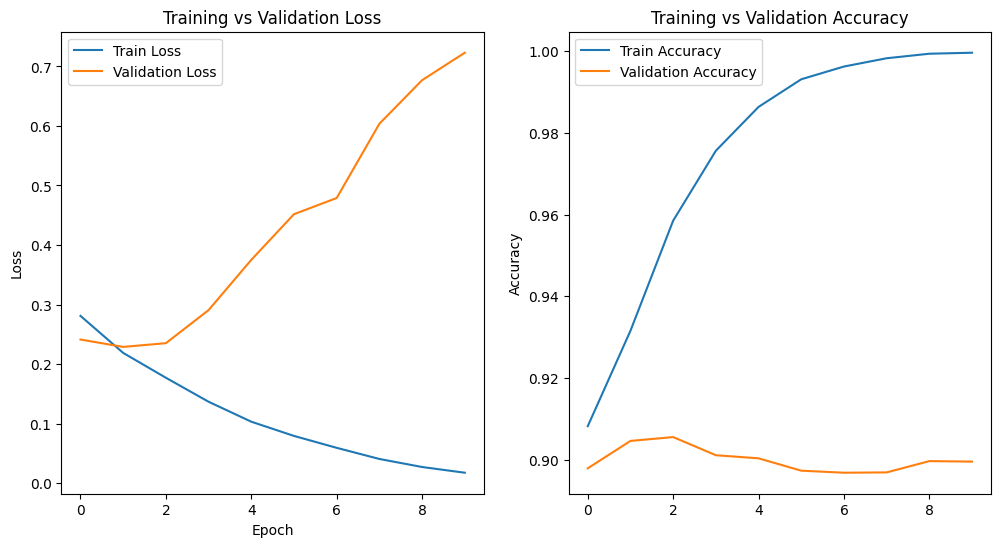

In [10]:
num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list = get_history("./BERT-Yelp-0/checkpoint-203130/trainer_state.json")

epoch_list = [i for i in range(num_epochs_trained)]
_, ax = plt.subplots(nrows = 1, ncols=2, figsize=(12,6))
ax[0].plot(epoch_list, train_loss_list)
ax[0].plot(epoch_list, val_loss_list)
ax[0].legend(["Train Loss", "Validation Loss"])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training vs Validation Loss")

ax[1].plot(epoch_list, train_acc_list)
ax[1].plot(epoch_list, val_acc_list)
ax[1].legend(["Train Accuracy", "Validation Accuracy"])
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training vs Validation Accuracy")